<a href="https://colab.research.google.com/github/Mikhaelyes/Data_Analysis_Practice/blob/main/Shaduling_Optimization_Problem/Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лабораторная работа Васильева Михаила Владимировича М01-307в 2023 год осень.
В работе запрограммированы 5 примеров задач из теории рассписаний с использованием библиотеки pyomo и нескольких решателей.
Материал по коду взят из https://jckantor.github.io/ND-Pyomo-Cookbook/README.html

Раздел 4.2 Machine Bottleneck.
В первой ячейке расположен код подключения решателя LP задач: "cbc".

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import shutil
import sys
import os.path

# test for pyomo and install if necessary
if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

# test for cbc and install if necessary
if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *
from pyomo.gdp import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.9 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3

Объявление работ - создание словаря с данными начала и конца работ, а так же с продолжительностью.

In [ ]:
JOBS = {
    'A': {'release': 1, 'duration': 2, 'due': 2},
    'B': {'release': 2, 'duration': 1, 'due': 3},
    'C': {'release': 2, 'duration': 2, 'due': 4},
    'D': {'release': 7, 'duration': 2, 'due': 8},
}


Функция Гранта отвечает за вывод диаграммы Гранта. Обычно используется после применения решателя.

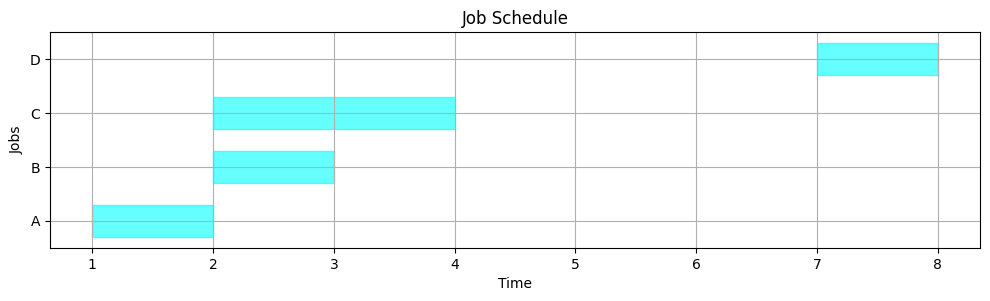

In [ ]:
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='cyan', alpha=0.6)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='red', alpha=0.5)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()

gantt(JOBS)

In [ ]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}
    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE

SCHEDULE = schedule(JOBS)
SCHEDULE

{'A': {'start': 1, 'finish': 3},
 'B': {'start': 3, 'finish': 4},
 'C': {'start': 4, 'finish': 6},
 'D': {'start': 7, 'finish': 9}}

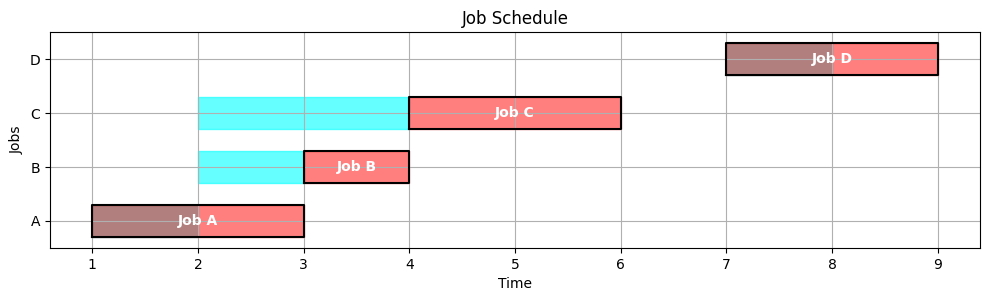

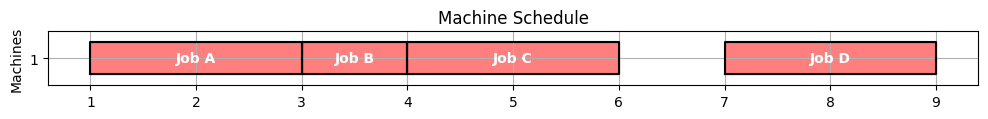

In [ ]:
gantt(JOBS, SCHEDULE)

Функция вывода основных параметров определяющих эффективность метода решения.

In [ ]:
def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    return KPI

kpi(JOBS, SCHEDULE)

{'Makespan': 9,
 'Max Pastdue': 2,
 'Sum of Pastdue': 5,
 'Number Pastdue': 4,
 'Number on Time': 0,
 'Fraction on Time': 0.0}

В первой задаче основной проблемой является задание времён начала работ через ограничения. Стоит помнить, что конструкции типа if нельзя передавать как ограничения в решатель.

In [ ]:
JOBS = {
    'A': {'release': 1, 'duration': 1, 'due': 12},
    'B': {'release': 1, 'duration': 1, 'due': 12},
    'C': {'release': 1, 'duration': 1, 'due': 12},
    'D': {'release': 1, 'duration': 1, 'due': 12},
    'E': {'release': 1, 'duration': 1, 'due': 12},
    'F': {'release': 1, 'duration': 1, 'due': 12},
    'G': {'release': 1, 'duration': 1, 'due': 12},
}

MACHINES = ['M1','M2']



m2 = ConcreteModel()

    # инициализация основных списков модели.
m2.J = Set(initialize=JOBS.keys())
m2.M = Set(initialize=MACHINES)
m2.PAIRS = Set(initialize = m2.J * m2.J, dimen=2, filter=lambda m2, j, k : j < k)
m2.M[1]

position is deprecated.  Please use at()  (deprecated in 6.1, will be
removed in (or after) 7.0)
(called from <ipython-input-9-19c44d1a866b>:21)


'M1'

In [ ]:
def graph_input ():
    #G = np.zeros ((size, size))
    G = np.array (([0, 1, 0, 0, 0],
                   [0, 0, 1, 1, 0],
                   [0, 0, 0, 0, 1],
                   [0, 0, 0, 0, 1],
                   [0, 0, 0, 0, 0]))
    J = np.array (([1, 1, 12],
                   [1, 1, 12],
                   [1, 1, 12],
                   [1, 1, 12],
                   [1, 1, 12]))
    return G, J

def j_to_jobs (J):
    res = {}
    letter = "A"
    for i in J:
        d = {'release': i [0], 'duration': i [1], 'due': i [2]}
        res [letter] = d
        letter = chr(ord (letter) + 1)
    return res

def g_to_constraints (G, m):
    #for i in range (len (G)):
    #    for j in range (len (G)):
    #        if (G [i] [j]):
    #            l1 = chr (ord ("A") + i)
    #            l2 = chr (ord ("A") + j)
    #            if not (m.start[l2] >= (m.start[l1] + JOBS[l1]['duration'])):
    #                return 0
    #return 1
    x = m.start['B'] >= (m.start['A'] + JOBS['A']['duration'])
    #y = m.start['C'] >= (m.start['A'] + JOBS['A']['duration'])
    y = m.start['B'] * 1 + m.start['A'] * 0
    print ("X = ", type (x), x)
    sum =
    return x

SyntaxError: invalid syntax (<ipython-input-10-da860f8a9866>, line 37)

In [ ]:
model = ConcreteModel ()
model.A = RangeSet(1, 10)
model.a = Param(model.A, within=PositiveReals)
model.ToBuy = Var(model.A)


def bud_rule(model, i):
    return model.a[i] * model.ToBuy[i] <= i


aBudget = Constraint(model.A, rule=bud_rule)
model.pprint ()

In [ ]:
#Пример №1

#Задание списка машин
MACHINES = ['M1','M2']

#Задание словаря работ
G, J = graph_input ()
JOBS = j_to_jobs (J)

#Создание метода решения
def schedule_machines(JOBS, MACHINES):

    # Создание модели pyomo
    m = ConcreteModel()

    # инициализация основных списков модели.
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # инициализация переменных модели с ограничениями на значения (от 0 до 1000) или NonNegativeReals
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)

    #разница между реальным окончанием работы и директивным
    m.pastdue    = Var(m.J, domain=NonNegativeReals)

    #разница между реальным окончанием работы и директивным
    m.early      = Var(m.J, domain=NonNegativeReals)

    # переменные модели которые будут использоваться в ограничениях
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # матрица бинарного соответствия работ машинам
    m.z = Var(m.J, m.M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)

    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    #задание функции которую необходимо минимизировать. В данном случае - время окончание всех работ.
    m.OBJ = Objective(expr = m.makespan, sense = minimize)


    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])

    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])

    #задание условия, что одна работа не может выполняться на нескольких машинах. Внимание стоит обратить на синтаксис без if
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)

    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])

    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)


    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] <= m.makespan)

    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))


    #в следующием коде задаётся граф выполнения работ
    #m.c7 = Constraint(expr = m.start['B'] >= (m.start['A'] + JOBS['A']['duration']))
    #m.c8 = Constraint(expr = m.start['C'] >= (m.start['A'] + JOBS['A']['duration']))
    #m.c13 = Constraint(expr = m.start['D'] >= (m.start['B'] + JOBS['B']['duration']))
    #m.c14 = Constraint(expr = m.start['D'] >= (m.start['C'] + JOBS['C']['duration']))
    #m.c10 = Constraint(expr = m.start['E'] >= (m.start['B'] + JOBS['B']['duration']))
    #m.c11 = Constraint(expr = m.start['F'] >= (m.start['C'] + JOBS['C']['duration']))
    #m.c12 = Constraint(expr = m.start['G'] >= (m.start['F'] + JOBS['F']['duration']))
    #метод решения
    m.c7 = Constraint (rule = g_to_constraints (G, m))
    SolverFactory('cbc').solve(m).write()

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE

SCHEDULE = schedule_machines(JOBS,MACHINES)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

In [ ]:
#Пример №2

#Пример кода для одной машины. Следует изучать отдельно от предыдущего.

JOBS = {
    'A': {'release': 1, 'duration': 2, 'due': 2},
    'B': {'release': 2, 'duration': 1, 'due': 3},
    'C': {'release': 2, 'duration': 2, 'due': 4},
    'D': {'release': 7, 'duration': 2, 'due': 8},
}

def opt_schedule(JOBS):

    # create model
    m = ConcreteModel()

    # index set to simplify notation
    m.J = Set(initialize=JOBS.keys())
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    #верхние границы того, сколько времени потребуется для обработки всех заданий
    # upper bounds on how long it would take to process all jobs
    tmax = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    # decision variables
    m.start      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
    m.pastdue    = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))
    m.early      = Var(m.J, domain=NonNegativeReals, bounds=(0, tmax))

    # additional decision variables for use in the objecive
    m.makespan   = Var(domain=NonNegativeReals, bounds=(0, tmax))
    m.maxpastdue = Var(domain=NonNegativeReals, bounds=(0, tmax))
    m.ispastdue  = Var(m.J, domain=Binary)

    # objective function
    #По сути из решения в Pyomo Cookbook необходимо лишь изменить целевую функцию.
    m.OBJ = Objective(expr = m.maxpastdue, sense = minimize)

    # constraints
    m.c1 = Constraint(m.J, rule=lambda m, j: m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Disjunction(m.PAIRS, rule=lambda m, j, k:
        [m.start[j] + JOBS[j]['duration'] <= m.start[k],
         m.start[k] + JOBS[k]['duration'] <= m.start[j]])

    m.c4 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= m.maxpastdue)
    m.c5 = Constraint(m.J, rule=lambda m, j: m.start[j] + JOBS[j]['duration'] <= m.makespan)
    m.c6 = Constraint(m.J, rule=lambda m, j: m.pastdue[j] <= tmax*m.ispastdue[j])



    TransformationFactory('gdp.chull').apply_to(m)
    SolverFactory('cbc').solve(m).write()

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {'machine': 1, 'start': m.start[j](), 'finish': m.start[j]() + JOBS[j]['duration']}

    return SCHEDULE

SCHEDULE = opt_schedule(JOBS)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

In [ ]:
#Пример №3
#Для решения необходимо разобраться в 1 примере. По сути всё отличие - грамотная запись ограничений типа принадлежность работы машине
#(Для этого есть функция бинарной принадлежности z) и ограничения на последовательность работ.

MACHINES = ['M1', 'M2', 'M3']

JOBS = {
    '11': {'release': 0, 'duration': 1, 'due': 8},
    '12': {'release': 0, 'duration': 1, 'due': 8},
    '13': {'release': 0, 'duration': 1, 'due': 8},
    '14': {'release': 0, 'duration': 1, 'due': 8},
    '21': {'release': 0, 'duration': 1, 'due': 8},
    '22': {'release': 0, 'duration': 1, 'due': 8},
    '31': {'release': 0, 'duration': 1, 'due': 8},
    '32': {'release': 0, 'duration': 1, 'due': 8},
    '41': {'release': 0, 'duration': 1, 'due': 8},
    '42': {'release': 0, 'duration': 1, 'due': 8},
    '43': {'release': 0, 'duration': 1, 'due': 8},
    '51': {'release': 0, 'duration': 1, 'due': 8},
    '52': {'release': 0, 'duration': 1, 'due': 8},
    '53': {'release': 0, 'duration': 1, 'due': 8},
    '54': {'release': 0, 'duration': 1, 'due': 8},
}


def schedule_machines(JOBS, MACHINES):

    # create model
    m = ConcreteModel()

    # index set to simplify notation
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # decision variables
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)

    # additional decision variables for use in the objecive
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # for binary assignment of jobs to machines
    m.z = Var(m.J, m.M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)
    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    m.OBJ = Objective(expr = m.makespan, sense = minimize)

    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)
    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])
    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)
    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] <= m.makespan)
    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    #запись ограничений на выполнение работ пар (работа, машина)
    #По сути ничего хитрого - проверяем бинарную принадлежность для каждой работы и машины в соответствии с таблицей

    m.c11 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['11', 'M1'] == 1)
    m.c12 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['12', 'M3'] == 1)
    m.c13 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['13', 'M2'] == 1)
    m.c14 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['14', 'M1'] == 1)
    m.c21 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['21', 'M2'] == 1)
    m.c22 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['22', 'M3'] == 1)
    m.c31 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['31', 'M3'] == 1)
    m.c32 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['32', 'M1'] == 1)
    m.c41 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['41', 'M1'] == 1)
    m.c42 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['42', 'M3'] == 1)
    m.c43 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['43', 'M1'] == 1)
    m.c51 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['51', 'M3'] == 1)
    m.c52 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['52', 'M1'] == 1)
    m.c53 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['53', 'M2'] == 1)
    m.c54 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k: m.z['54', 'M3'] == 1)

    #запись ограничений на последовательность работ
    #Просто запись что начало второй работы больше чем конец первой (В соответствии с таблицей)

    m.p11 = Constraint(expr = m.start['12'] >= (m.start['11'] + JOBS['11']['duration']))
    m.p12 = Constraint(expr = m.start['13'] >= (m.start['12'] + JOBS['12']['duration']))
    m.p13 = Constraint(expr = m.start['14'] >= (m.start['13'] + JOBS['13']['duration']))
    m.p21 = Constraint(expr = m.start['22'] >= (m.start['21'] + JOBS['21']['duration']))
    m.p31 = Constraint(expr = m.start['32'] >= (m.start['31'] + JOBS['31']['duration']))
    m.p41 = Constraint(expr = m.start['42'] >= (m.start['41'] + JOBS['41']['duration']))
    m.p42 = Constraint(expr = m.start['43'] >= (m.start['42'] + JOBS['42']['duration']))
    m.p51 = Constraint(expr = m.start['52'] >= (m.start['51'] + JOBS['51']['duration']))
    m.p52 = Constraint(expr = m.start['53'] >= (m.start['52'] + JOBS['52']['duration']))
    m.p53 = Constraint(expr = m.start['54'] >= (m.start['53'] + JOBS['53']['duration']))

    SolverFactory('cbc').solve(m).write()

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE

SCHEDULE = schedule_machines(JOBS,MACHINES)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

In [ ]:
#Пример №4


MACHINES = ['M1', 'M2', 'M3']


JOBS = {
    '1': {'release': 0, 'duration': [10, 6, 1], 'due': 5},
    '2': {'release': 0, 'duration': [5, 20, 3], 'due': 5},
    '3': {'release': 0, 'duration': [9, 30, 1], 'due': 6},
    '4': {'release': 0, 'duration': [6, 5, 10], 'due': 7},
}


def schedule_machines(JOBS, MACHINES):

    # create model
    m = ConcreteModel()

    # index set to simplify notation
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # decision variables
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)

    #вводим дополнительную переменную модели как длительность
    m.duration   = Var(m.J, domain=NonNegativeReals)

    # additional decision variables for use in the objecive
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # for binary assignment of jobs to machines
    m.z = Var(m.J, m.M, domain=Binary)


    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)
    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([max(JOBS[j]['duration']) for j in m.J])

    m.OBJ = Objective(expr = m.maxpastdue, sense = minimize)

    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + m.duration[j] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)
    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])
    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)
    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + m.duration[j] <= m.makespan)
    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + m.duration[j] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + m.duration[j] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    #По сути нужно лишь дополнить одно ограничение. А именно равенство m.duration и суммы произведений продолжительностей работ из таблицы
    #Умноженных на матрицу бинарного соответствия z. Так как ограничение С3 задает налицие одной единице в столбце Z - происходит отбор
    #наилучшей продолжительности
    m.c33 = Constraint(m.J, rule=lambda m, j: m.duration[j] == (m.z[j,'M1']*JOBS[j]['duration'][0] +
            m.z[j,'M2']*JOBS[j]['duration'][1] + m.z[j,'M3']*JOBS[j]['duration'][2]))


    SolverFactory('cbc').solve(m).write()

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + m.duration[j](),
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE


SCHEDULE = schedule_machines(JOBS, MACHINES)

gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

In [ ]:
#Подключение решателя нелинейных задач необходимого для примера 5

%%capture
import sys
import os
from pyomo.environ import *
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
%load_ext autoreload
!conda install -c conda-forge bonmin


if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc

!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

!wget -N -q "https://ampl.com/dl/open/bonmin/bonmin-linux64.zip"
!unzip -o -q bonmin-linux64

!wget -N -q "https://ampl.com/dl/open/couenne/couenne-linux64.zip"
!unzip -o -q couenne-linux64

!wget -N -q "https://ampl.com/dl/open/gecode/gecode-linux64.zip"
!unzip -o -q gecode-linux64

In [ ]:
#Пример №5
#Основной трюк - сведение задачи разбиения на группы к задаче поиска машин. Ибо лень всему голова.
#Задаём количество машин равное количеству элементов выборки (Максимальное количество групп)
#И записываем грамотно objective функцию которую надо минимизировать.

MACHINES = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6']

JOBS = {
    'A': {'release': 0, 'duration': 3, 'due': 20},
    'B': {'release': 0, 'duration': 2, 'due': 20},
    'C': {'release': 0, 'duration': 2, 'due': 20},
    'D': {'release': 0, 'duration': 3, 'due': 20},
    'E': {'release': 0, 'duration': 1, 'due': 20},
    'F': {'release': 0, 'duration': 1, 'due': 20},
}

W = [1, 2, 1, 1, 4, 4]

def objective(JOBS, MACHINES, W, z):
  TMAX = [[0 for _ in range(len(MACHINES))] for _ in range(len(JOBS))]
  ZMAX = [[0 for _ in range(len(MACHINES))] for _ in range(len(JOBS))]
  MAX = [0] * len(MACHINES)
  MAX_adapt = [0] * len(MACHINES)
  string = list(JOBS.keys())

  for j in range(len(MACHINES)):
    for i in range(len(JOBS)):
      TMAX[i][j] = JOBS[string[i]]['duration'] * z[string[i], MACHINES[j]]
      ZMAX[i][j] = z[string[i], MACHINES[j]] * W[i]
      MAX[j] += TMAX[i][j]

  MAX_adapt[0] = MAX[0] + 1
  MAX_adapt[1] = MAX[0] + MAX[1] + 2
  MAX_adapt[2] = MAX[0] + MAX[1] + MAX[2] + 3
  MAX_adapt[3] = MAX[0] + MAX[1] + MAX[2] + MAX[3] + 4
  MAX_adapt[4] = MAX[0] + MAX[1] + MAX[2] + MAX[3] + MAX[4] + 5
  MAX_adapt[5] = MAX[0] + MAX[1] + MAX[2] + MAX[3] + MAX[4] + MAX[5] + 6

  objective = 0
  for j in range(len(MACHINES)):
    objective += MAX_adapt[j] * sum([ZMAX[i][j] for i in range(len(JOBS))])

  return objective


def schedule_machines(JOBS, MACHINES, W):
    # create model
    m = ConcreteModel()

    # index set to simplify notation
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)


    # decision variables
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdue    = Var(m.J, domain=NonNegativeReals)
    m.early      = Var(m.J, domain=NonNegativeReals)

    # additional decision variables for use in the objecive
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # for binary assignment of jobs to machines
    m.z = Var(m.J, m.M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)
    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    #m.OBJ = Objective(expr = m.makespan, sense = minimize)
    m.OBJ = Objective(expr = objective(JOBS, MACHINES, W, m.z), sense = minimize)

    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])
    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)
    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])
    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)
    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] <= m.makespan)
    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM * (m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))
    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))


    SolverFactory('bonmin').solve(m).write()
#    SolverFactory('cbc').solve(m).write()

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE

SCHEDULE = schedule_machines(JOBS,MACHINES, W)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

Эвристика

In [ ]:
#Пример №1

#Задание списка машин
MACHINES = ['M1','M2']

#Задание словаря работ

JOBS = {
    'A': {'release': 1, 'duration': 1, 'due': 12},
    'B': {'release': 1, 'duration': 1, 'due': 12},
    'C': {'release': 1, 'duration': 1, 'due': 12},
    'D': {'release': 1, 'duration': 1, 'due': 12},
    'E': {'release': 1, 'duration': 1, 'due': 12},
    'F': {'release': 1, 'duration': 1, 'due': 12},
    'G': {'release': 1, 'duration': 1, 'due': 12},
}

#Создание метода решения
def schedule_machines(JOBS, MACHINES):

    # Создание модели pyomo
    m = ConcreteModel()

    # инициализация основных списков модели.
    m.J = Set(initialize=JOBS.keys())
    m.M = Set(initialize=MACHINES)
    m.PAIRS = Set(initialize = m.J * m.J, dimen=2, filter=lambda m, j, k : j < k)

    # инициализация переменных модели с ограничениями на значения (от 0 до 1000) или NonNegativeReals
    m.start      = Var(m.J, bounds=(0, 1000))
    m.makespan   = Var(domain=NonNegativeReals)

    #разница между реальным окончанием работы и директивным
    m.pastdue    = Var(m.J, domain=NonNegativeReals)

    #разница между реальным окончанием работы и директивным
    m.early      = Var(m.J, domain=NonNegativeReals)

    # переменные модели которые будут использоваться в ограничениях
    m.ispastdue  = Var(m.J, domain=Binary)
    m.maxpastdue = Var(domain=NonNegativeReals)

    # матрица бинарного соответствия работ машинам
    m.z = Var(m.J, m.M, domain=Binary)

    # for modeling disjunctive constraints
    m.y = Var(m.PAIRS, domain=Binary)

    BigM = max([JOBS[j]['release'] for j in m.J]) + sum([JOBS[j]['duration'] for j in m.J])

    #задание функции которую необходимо минимизировать. В данном случае - время окончание всех работ.
    m.OBJ = Objective(expr = m.makespan, sense = minimize)


    m.c1 = Constraint(m.J, rule=lambda m, j:
            m.start[j] >= JOBS[j]['release'])

    m.c2 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.pastdue[j])

    #задание условия, что одна работа не может выполняться на нескольких машинах. Внимание стоит обратить на синтаксис без if
    m.c3 = Constraint(m.J, rule=lambda m, j:
            sum(m.z[j,mach] for mach in m.M) == 1)

    m.c4 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= BigM*m.ispastdue[j])

    m.c5 = Constraint(m.J, rule=lambda m, j:
            m.pastdue[j] <= m.maxpastdue)


    m.c6 = Constraint(m.J, rule=lambda m, j:
            m.start[j] + JOBS[j]['duration'] <= m.makespan)

    m.d1 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[j] + JOBS[j]['duration'] <= m.start[k] + BigM*(m.y[j,k] + (1-m.z[j,mach]) + (1-m.z[k,mach])))

    m.d2 = Constraint(m.M, m.PAIRS, rule = lambda m, mach, j, k:
            m.start[k] + JOBS[k]['duration'] <= m.start[j] + BigM*((1-m.y[j,k]) + (1-m.z[j,mach]) + (1-m.z[k,mach])))


    #в следующием коде задаётся граф выполнения работ
    m.c7 = Constraint(expr = m.start['B'] >= (m.start['A'] + JOBS['A']['duration']))
    m.c8 = Constraint(expr = m.start['C'] >= (m.start['A'] + JOBS['A']['duration']))
    m.c13 = Constraint(expr = m.start['D'] >= (m.start['B'] + JOBS['B']['duration']))
    m.c14 = Constraint(expr = m.start['D'] >= (m.start['C'] + JOBS['C']['duration']))
    m.c10 = Constraint(expr = m.start['E'] >= (m.start['B'] + JOBS['B']['duration']))
    m.c11 = Constraint(expr = m.start['F'] >= (m.start['C'] + JOBS['C']['duration']))
    m.c12 = Constraint(expr = m.start['G'] >= (m.start['F'] + JOBS['F']['duration']))
    #метод решения
    m.c7 = Constraint (rule = g_to_constraints (G, m))
    SolverFactory('cbc').solve(m).write()

    SCHEDULE = {}
    for j in m.J:
        SCHEDULE[j] = {
            'start': m.start[j](),
            'finish': m.start[j]() + JOBS[j]['duration'],
            'machine': [mach for mach in MACHINES if m.z[j,mach]()][0]
        }

    return SCHEDULE

SCHEDULE = schedule_machines(JOBS,MACHINES)
gantt(JOBS, SCHEDULE)
kpi(JOBS, SCHEDULE)

NameError: name 'g_to_constraints' is not defined